In [1]:
# !pip install imblearn
# !pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tqdm.keras import TqdmCallback

import Model

2024-07-08 19:44:43.191816: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 19:44:44.016795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def extract_features(X, feature):
    mfcc = X[:, :, :20]
    chroma = X[:, :, 21:33]
    zcr = X[:, :, 20][:, :, np.newaxis]
    rms = X[:, :, 33][:, :, np.newaxis]
    centroid = X[:, :, 34][:, :, np.newaxis]
    bandwidth = X[:, :, 35][:, :, np.newaxis]
    rolloff = X[:, :, 36][:, :, np.newaxis]
    
    if feature == "full":
        return X
    elif feature == "without_mfcc":
        return np.concatenate((zcr, chroma, rms, centroid, bandwidth, rolloff), axis=2)
    elif feature == "without_chroma":
        return np.concatenate((mfcc, zcr, rms, centroid, bandwidth, rolloff), axis=2)
    elif feature == "without_mfcc_and_chroma":
        return np.concatenate((zcr, rms, centroid, bandwidth, rolloff), axis=2)
    elif feature == "mfcc":
        return mfcc
    elif feature == "chroma":
        return chroma
    elif feature == "mfcc_and_chroma":
        return np.concatenate((mfcc, chroma), axis=2)
    else:
        raise ValueError("Invalid feature option")

In [4]:
dataset = np.load("Dataset/Mujawwad1_(hop=5).npz")

features = dataset["features"]
labels = dataset["labels"]

X = features
y = labels

X = extract_features(X, "full")

mean = np.mean(X, axis=(0, 1))
std = np.std(X, axis=(0, 1))
X = (X - mean) / std

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

X_train = np.mean(X_train, axis=1)
X_test = np.mean(X_test, axis=1)
X_val = np.mean(X_val, axis=1)

# Reshape the data for Conv1D
X_train = X_train[..., np.newaxis]  # Shape: (samples, features, 1)
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]

In [6]:
# Perform Training Again
model = Model.cnn_1d(X_train)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(
    monitor="accuracy", 
    patience=5
)
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/200


2024-07-08 19:46:19.397096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38151 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:47:00.0, compute capability: 8.0
I0000 00:00:1720442782.062420   89257 service.cc:145] XLA service 0x7f3d28015910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720442782.062485   89257 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 7g.40gb, Compute Capability 8.0
2024-07-08 19:46:22.152515: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-08 19:46:23.867260: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


31/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1762 - loss: 2.4805 

I0000 00:00:1720442793.194709   89257 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 220ms/step - accuracy: 0.1716 - loss: 2.4856 - val_accuracy: 0.2164 - val_loss: 1.9343
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1658 - loss: 2.4212 - val_accuracy: 0.1847 - val_loss: 1.9362
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1847 - loss: 2.2970 - val_accuracy: 0.1728 - val_loss: 1.9291
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1914 - loss: 2.2830 - val_accuracy: 0.2071 - val_loss: 1.9199
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1951 - loss: 2.2029 - val_accuracy: 0.2401 - val_loss: 1.9105
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2227 - loss: 2.1144 - val_accuracy: 0.2427 - val_loss: 1.8973
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2389 - loss: 2.1540 - val_accuracy: 0.2546 - val_loss: 1.8644
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2200 - loss: 2.1259 - val_accuracy: 0.2784 - val_loss: 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6863 - loss: 1.0624 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


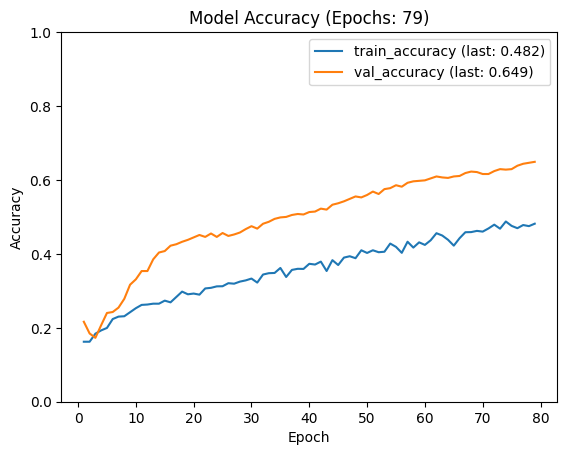

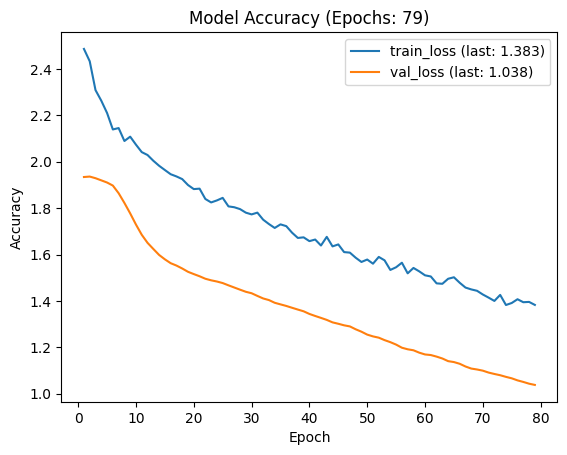

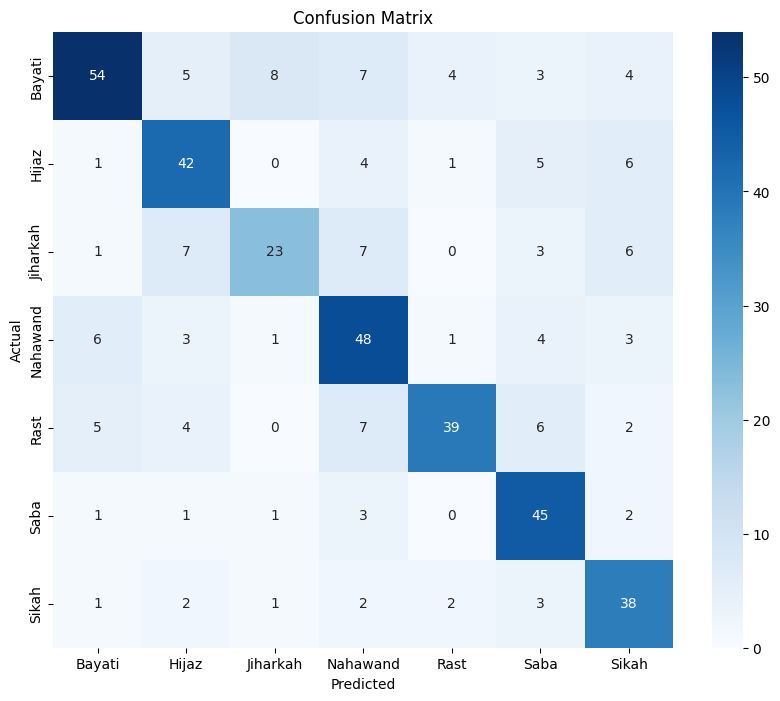

In [9]:
# Extract the data
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)
last_epoch = len(train_accuracy)
last_train_acc = train_accuracy[-1]
last_val_acc = val_accuracy[-1]
last_train_loss = train_loss[-1]
last_val_loss = val_loss[-1]

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# Plot Model Accuracy
plt.plot(epochs, train_accuracy, label=f'train_accuracy (last: {last_train_acc:.3f})')
plt.plot(epochs, val_accuracy, label=f'val_accuracy (last: {last_val_acc:.3f})')
plt.title(f'Model Accuracy (Epochs: {last_epoch})')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Model Loss
plt.plot(epochs, train_loss, label=f'train_loss (last: {last_train_loss:.3f})')
plt.plot(epochs, val_loss, label=f'val_loss (last: {last_val_loss:.3f})')
plt.title(f'Model Accuracy (Epochs: {last_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
maqams = ["Bayati", "Hijaz", "Jiharkah", "Nahawand", "Rast", "Saba", "Sikah"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=maqams, yticklabels=maqams)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()